In [100]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label,regionprops
from PIL import Image
import os

In [101]:
def image_directory(time, slice):
    image_dir = 'entry' + str(time).zfill(4) + '_no_extpag_db0100_vol_' + str(slice).zfill(6) + '.tiff'
    dir = os.path.join(time_directory(time), image_dir)
    return dir

def time_directory(time):
    time_dir = 'entry' + str(time).zfill(4) + '_no_extpag_db0100_vol'
    return time_dir

In [126]:
def print_segmented_image(exp, time, slice, threshold, n_agglomerates):
    
    parent_dir = 'Z:\\Reconstructions\\' + exp
    os.chdir(parent_dir)

    image = Image.open(image_directory(time, slice))
    image = np.array(image)
    image = (image - np.min(image))/(np.max(image) - np.min(image))

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(image, cmap='Greys_r')

    mask = image > threshold
    mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)

    rps = regionprops(mask_labeled)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    new_mask = np.zeros_like(mask_labeled)
    for i in idxs[:n_agglomerates]:
        new_mask[tuple(rps[i].coords.T)] = i + 1
    uniform = np.copy(new_mask)
    uniform[uniform > 0] = 1
    axes[1].imshow(uniform, cmap='Greys_r')
    colored = np.copy(new_mask)
    colored[colored > 0] = colored[colored > 0] + n_agglomerates/10
    axes[2].imshow(colored, cmap='nipy_spectral')
    plt.savefig(str(exp) + '_' + str(time).zfill(4) + '_' + str(slice).zfill(6) + '_segmented.png', dpi=600)
    fig.suptitle(str(exp) + ', time=' + str(time).zfill(4) + ', slice=' + str(slice).zfill(6) + ', threshold=' + str(threshold) + ', agglomerates=' + str(n_agglomerates))

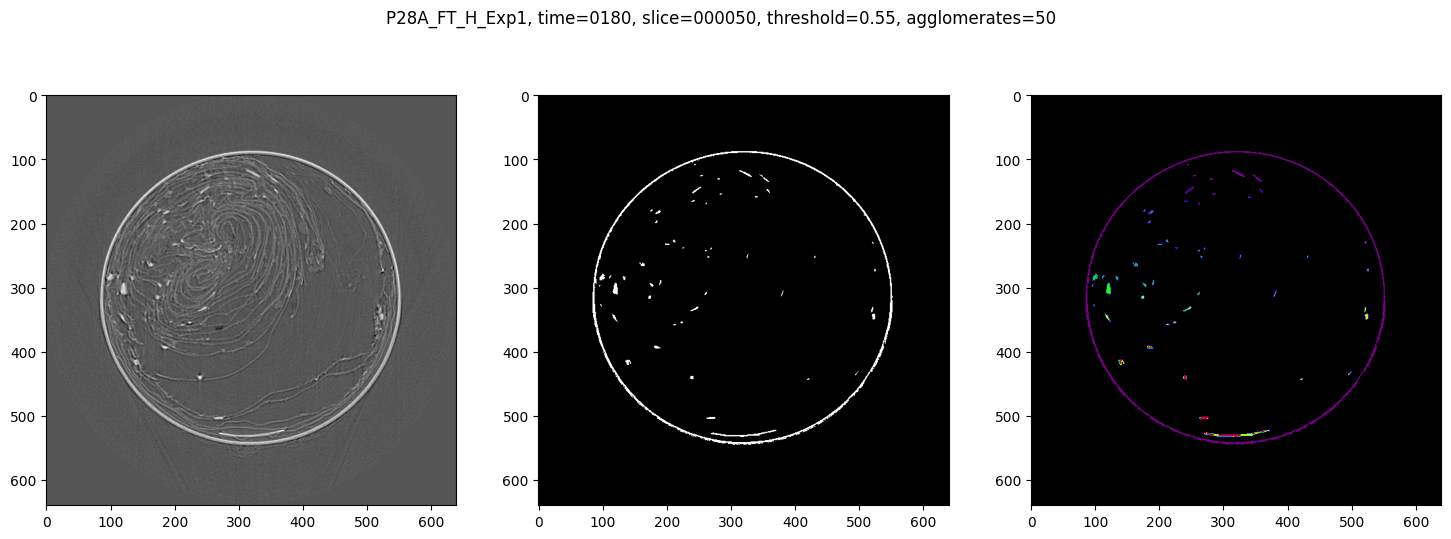

In [128]:
print_segmented_image(exp='P28A_FT_H_Exp1', time=180, slice=50, threshold=0.55, n_agglomerates=50)